Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

Import other packages

In [2]:
from dlclive import DLCLive, Processor
import cv2
from tqdm import tqdm

/home/sachinks/anaconda3/envs/dlc-live/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Video metadata

In [3]:
xls_filepath = '/home/sachinks/Code/MyProjects/OctopusVideos1/Movement_class_and_timestamps_end_stim.xlsx'
files_info = read_octopus_xlsx(xls_filepath)
video_filename = 'elec_left_cord_100Hz_5mA_220616_134220_000'

frame_count = None
fps = 30

Video stream data and model

In [4]:
video_path = f'/home/sachinks/Code/MyProjects/live_labelled/{video_filename}-1.mp4'

model_type = "mobilenet" # "resnet"
model_path = get_model_path(model_type)

dlc_proc = Processor()
dlc_live = DLCLive(
    model_path,
    processor=dlc_proc,
    pcutoff=0.2,
    resize=1,
    # cropping=[100, 520, 210, 400],
    # display=True,
    # dynamic=(True, 0.2, 50)
    )

video = cv2.VideoCapture(video_path)
frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

Start and end time

In [16]:
row = files_info[files_info['File Name'] == video_filename]
orig_start_end_time = row[['Start Time (s)', 'End Time (s)']].values[0]
stim_time = row['End (s)'].values[0]

start_end_time = add_time_margin(orig_start_end_time, total_time=frame_count/fps)
start_end_time[0] = min(start_end_time[0], stim_time)
start_end_time[1] += 4
stim_f = int(fps*stim_time)

start_f, end_f = (fps * start_end_time).astype(int)

tx = np.linspace(start_end_time[0], start_end_time[1], end_f-start_f)

Extracting features

In [6]:
def do_crop(pose, frame_shape, crop_params):
    detected = pose[:, 2] > crop_params[0]

    if np.any(detected):
        x = pose[detected, 0]
        y = pose[detected, 1]

        x1 = int(max([0, int(np.amin(x)) - crop_params[1]]))
        x2 = int(min([frame_shape[1], int(np.amax(x)) + crop_params[1]]))
        y1 = int(max([0, int(np.amin(y)) - crop_params[1]]))
        y2 = int(min([frame_shape[0], int(np.amax(y)) + crop_params[1]]))

        dynamic_cropping = [x1, x2, y1, y2]
        return dynamic_cropping
    else:
        return None

In [7]:
# clean pose using likelihood
DO_CLEANING = False
p_threshold = 0.9

feature_angles_array = []
pose_speed_array = []

prev_pose_xy = None

crop_params = (p_threshold, 20) # threshold, margin

full_dynamic_cropping = []

# Read and save each frame
for i in tqdm(range(frame_count)):
    # get current pose
    ret, frame = video.read()
    if not ret:
        break
    # frame = rgb_to_grayscale(frame)
    # TODO: find difference between init_inference & get_pose
    curr_pose = None
    if i == 0:
        curr_pose = dlc_live.init_inference(frame)
    else:
        curr_pose = dlc_live.get_pose(frame)
    
    curr_pose_xy, curr_pose_p = curr_pose[:, :-1], curr_pose[:, -1]
    if prev_pose_xy is None:
        prev_pose_xy = curr_pose_xy

    # replacing bad values with previous values
    if DO_CLEANING:
        bad_pose_mask = curr_pose_p < p_threshold
        curr_pose_xy[bad_pose_mask] = prev_pose_xy[bad_pose_mask]

    # do cropping
    dynamic_cropping = do_crop(np.concatenate([curr_pose_xy, curr_pose_p[:, None]], axis=1), frame.shape, crop_params)

    full_dynamic_cropping.append(dynamic_cropping)

    # do stuffs with current pose
    pose = np.stack([prev_pose_xy, curr_pose_xy])
    feature_angles, pose_speed = extract_pose_features(pose)
    feature_angles_array.append(feature_angles)
    pose_speed_array.append(pose_speed)

    # set previous pose
    prev_pose_xy = curr_pose_xy

feature_angles_array = np.array(feature_angles_array)
pose_speed_array = np.array(pose_speed_array)

full_dynamic_cropping = np.array(full_dynamic_cropping)

100%|██████████| 756/756 [00:11<00:00, 68.43it/s]


In [8]:
np.mean(full_dynamic_cropping, axis=0)

array([270.65079365, 363.97619048, 194.99603175, 290.23412698])

Plot results

elec_left_cord_100Hz_5mA_220616_134220_000


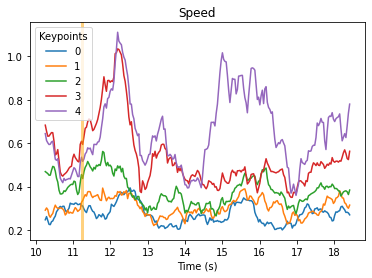

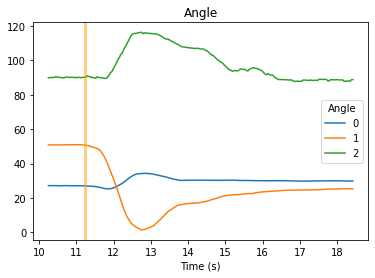

In [17]:
print(video_filename)

for i in range(5):
    data_smoothed = smooth_data(pose_speed_array[start_f: end_f, i])
    plt.plot(tx, data_smoothed, label=i)
plt.title("Speed")
plt.xlabel("Time (s)")
plt.legend(title="Keypoints")
plt.axvline(x=stim_time, color='orange', linewidth=3, alpha=0.5)
plt.show()

for k in range(3):
    data_smoothed = smooth_data(feature_angles_array[start_f: end_f, k])
    plt.plot(tx, data_smoothed, label=k)
plt.title("Angle")
plt.xlabel("Time (s)")
plt.legend(title="Angle")
plt.axvline(x=stim_time, color='orange', linewidth=3, alpha=0.5)
plt.show()